# Assignment set 2 

#### Job Marcelis, Ernani Hazbolatow, Koen Verlaan

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from src.gray_scott import plot_gray_scott, animate_gray_scott
from src.diffusion import plot_many_dla, compute_fractal_dimensions, stochastic_runs_fd, optimal_omega_eta
from src.mc_dla import run_single_mc_dla
from IPython.display import HTML

plt.rcParams['animation.embed_limit'] = 120

### Exercise 2.1: Diffusion Limited Aggregation

Termination at step 923 with 1
Termination at step 347 with 2


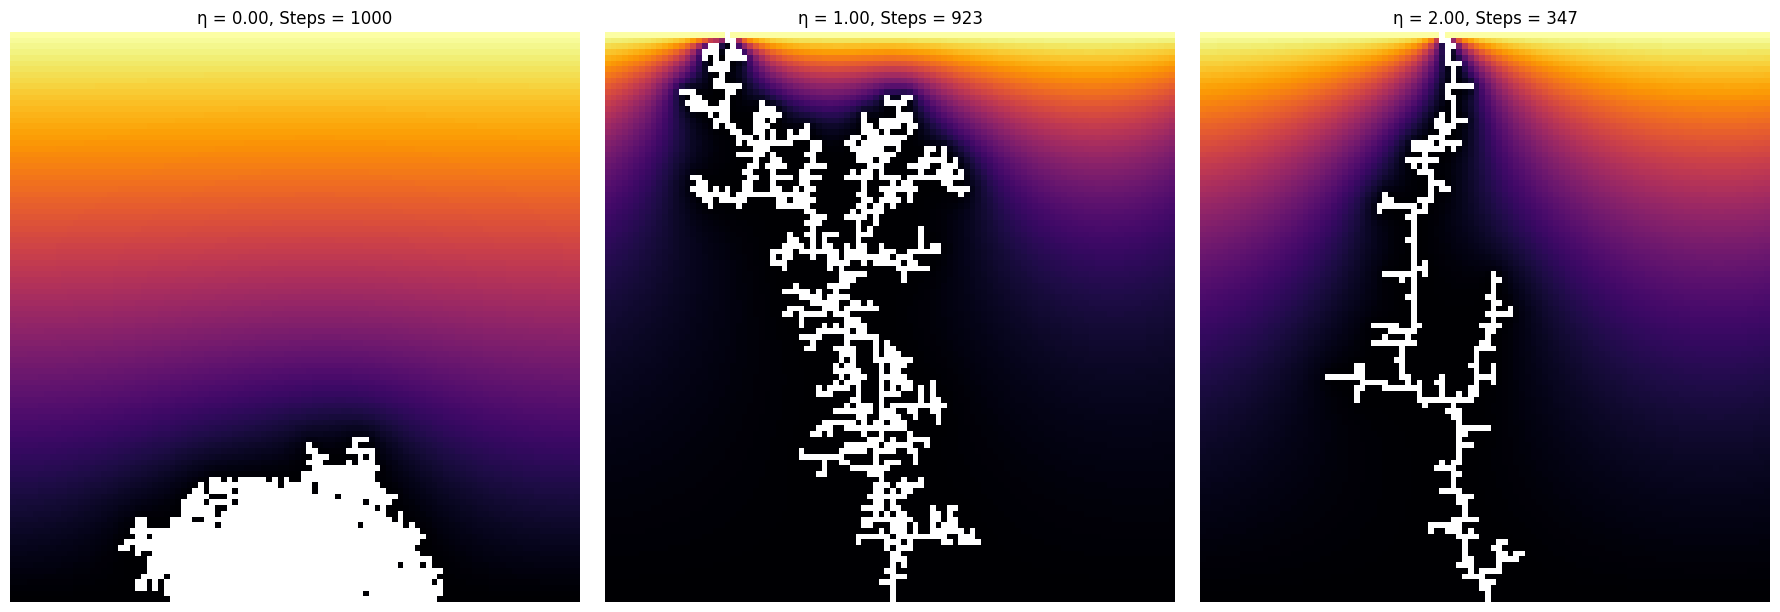

In [4]:
plot_many_dla((100, 100), [0, 1, 2], 1000)

Computing fractal dimension for η = 0.50
Termination at step 2713 with 0.5
Fractal Dimension for η=0.50: 1.740
Computing fractal dimension for η = 0.67
Termination at step 2246 with 0.6666666666666666
Fractal Dimension for η=0.67: 1.702
Computing fractal dimension for η = 0.83
Termination at step 1348 with 0.8333333333333333
Fractal Dimension for η=0.83: 1.517
Computing fractal dimension for η = 1.00
Termination at step 1018 with 1.0
Fractal Dimension for η=1.00: 1.475
Computing fractal dimension for η = 1.17
Termination at step 914 with 1.1666666666666665
Fractal Dimension for η=1.17: 1.447
Computing fractal dimension for η = 1.33
Termination at step 777 with 1.3333333333333333
Fractal Dimension for η=1.33: 1.438
Computing fractal dimension for η = 1.50
Termination at step 405 with 1.5
Fractal Dimension for η=1.50: 1.384
Computing fractal dimension for η = 1.67
Termination at step 436 with 1.6666666666666665
Fractal Dimension for η=1.67: 1.413
Computing fractal dimension for η = 1.83


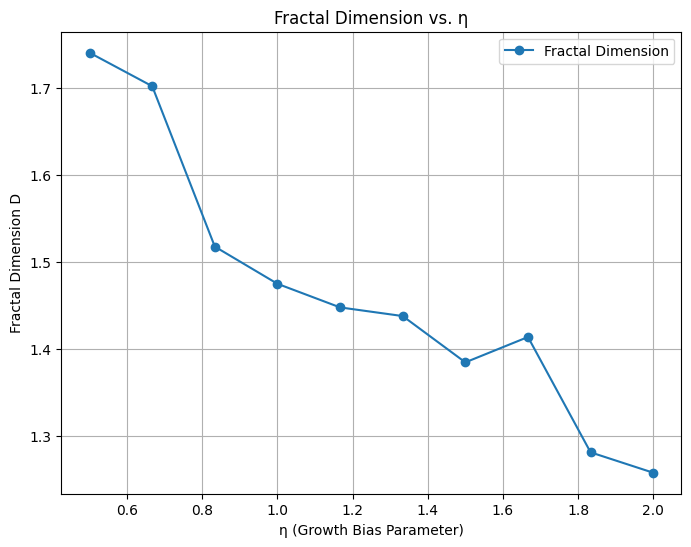

In [5]:
# Run for single iterations
eta_values = np.linspace(0.5, 2.0, 10)  
eta_vals, fractal_dims = compute_fractal_dimensions(eta_values)

# Plot results
plt.figure(figsize=(8, 6))
plt.plot(eta_vals, fractal_dims, marker='o', linestyle='-', label="Fractal Dimension")
plt.xlabel("η (Growth Bias Parameter)")
plt.ylabel("Fractal Dimension D")
plt.title("Fractal Dimension vs. η")
plt.legend()
plt.grid()
plt.show()

In [ ]:

# Run the function with multiple stochastic trials
eta_values = np.linspace(0.5, 2.0, 5)  
eta_vals, fractal_means, fractal_stds = stochastic_runs_fd(eta_values, runs=25, grid_size=(100,100))

# Save them into a .npz file
np.savez("stochastic_fractal100by100.npz", eta_vals=eta_vals, fractal_means=fractal_means, fractal_stds=fractal_stds)
data = np.load("stochastic_fractal100by100.npz")

# Extract them
eta_vals = data["eta_vals"]
fractal_means = data["fractal_means"]
fractal_stds = data["fractal_stds"]

# Plot the results with error bars
plt.figure(figsize=(8, 6))
plt.errorbar(eta_vals, fractal_means, yerr=fractal_stds, fmt='o-', label="Fractal Dimension (Mean ± Std)")
plt.xlabel("η (Growth Bias Parameter)")
plt.ylabel("Fractal Dimension D")
plt.title("Fractal Dimension vs. η (Averaged over Multiple Runs)")
plt.legend()
plt.grid()
plt.show()

Computing fractal dimension for η = 0.50 over 25 runs...
  Run 1/25 for η = 0.50
Termination at step 2281 with 0.5
  Run 2/25 for η = 0.50
Termination at step 2608 with 0.5
  Run 3/25 for η = 0.50
Termination at step 2481 with 0.5
  Run 4/25 for η = 0.50
Termination at step 2469 with 0.5
  Run 5/25 for η = 0.50
Termination at step 2555 with 0.5
  Run 6/25 for η = 0.50


In [ ]:

# Run the function with multiple stochastic trials
eta_values = np.linspace(0.5, 2.0, 5)  
eta_vals, fractal_means, fractal_stds = stochastic_runs_fd(eta_values, runs=25, grid_size=(200,200))

# Save them into a .npz file
np.savez("stochastic_fractal_200by200.npz", eta_vals=eta_vals, fractal_means=fractal_means, fractal_stds=fractal_stds)
data = np.load("stochastic_fractal_200by200.npz")

# Extract them
eta_vals = data["eta_vals"]
fractal_means = data["fractal_means"]
fractal_stds = data["fractal_stds"]

# Plot the results with error bars
plt.figure(figsize=(8, 6))
plt.errorbar(eta_vals, fractal_means, yerr=fractal_stds, fmt='o-', label="Fractal Dimension (Mean ± Std)")
plt.xlabel("η (Growth Bias Parameter)")
plt.ylabel("Fractal Dimension D")
plt.title("Fractal Dimension vs. η (Averaged over Multiple Runs)")
plt.legend()
plt.grid()
plt.show()

In [ ]:

grid_shape = (100, 100)
eta_values = np.linspace(0, 2.0, 10)       # 10 values for eta from 0.5 to 2.0
omega_values = np.linspace(1.0, 1.99, 10)       # 10 values for omega from 1.0 to 1.9
growth_steps = 3000

# Run experiments for each combination of eta and omega.
avg_iters = optimal_omega_eta(grid_shape, eta_values, omega_values, growth_steps=growth_steps)

# Create a meshgrid for plotting.
Omega, Eta = np.meshgrid(omega_values, eta_values)

# 3D Mesh Plot: x-axis: omega, y-axis: eta, z-axis: average iterations.
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(Omega, Eta, avg_iters, cmap='viridis', edgecolor='none')
ax.set_xlabel("Omega (ω)")
ax.set_ylabel("Eta (η)")
ax.set_zlabel("Average SOR Iterations")
ax.set_title(f"Average SOR Iterations vs. ω and η (Grid: {grid_shape}, Steps: {growth_steps})")
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

In [ ]:

grid_shape = (100, 100)
eta_values = np.linspace(0, 2.0, 10)       # 10 values for eta from 0.5 to 2.0
omega_values = np.linspace(1.7, 1.9, 10)       # 10 values for omega from 1.0 to 1.9
growth_steps = 3000

# Run experiments for each combination of eta and omega.
avg_iters = optimal_omega_eta(grid_shape, eta_values, omega_values, growth_steps=growth_steps)

# Create a meshgrid for plotting.
Omega, Eta = np.meshgrid(omega_values, eta_values)

# 3D Mesh Plot: x-axis: omega, y-axis: eta, z-axis: average iterations.
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(Omega, Eta, avg_iters, cmap='viridis', edgecolor='none')
ax.set_xlabel("Omega (ω)")
ax.set_ylabel("Eta (η)")
ax.set_zlabel("Average SOR Iterations")
ax.set_title(f"Average SOR Iterations vs. ω and η (Grid: {grid_shape}, Steps: {growth_steps})")
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

### Exercise 2.2: Monte Carlo DLA

100%|██████████| 5000/5000 [00:27<00:00, 180.34it/s]

No available positions to spawn walker
No available positions to spawn walker
No available positions to spawn walker
No available positions to spawn walker
No available positions to spawn walker
No available positions to spawn walker
No available positions to spawn walker
No available positions to spawn walker
No available positions to spawn walker
No available positions to spawn walker
No available positions to spawn walker
No available positions to spawn walker
No available positions to spawn walker
No available positions to spawn walker
No available positions to spawn walker
No available positions to spawn walker
No available positions to spawn walker
No available positions to spawn walker
No available positions to spawn walker
No available positions to spawn walker
No available positions to spawn walker
No available positions to spawn walker
No available positions to spawn walker
No available positions to spawn walker
No available positions to spawn walker
No available positions to

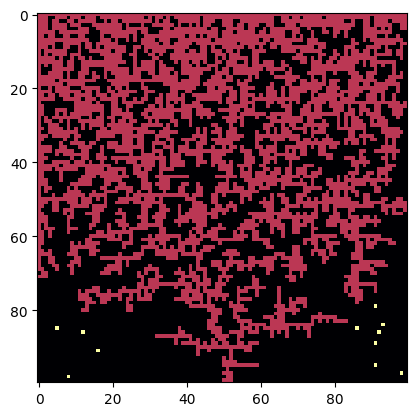

In [6]:
grid_size = 100
iterations = 5000
sticking_prob = 0.5

run_single_mc_dla(grid_size, iterations, sticking_prob)

### Exercise 2.3: The Gray-Scott model

The Gray-Scott model describes a system of chemical reaction where two different species $U$ and $V$ are present. The corresponding reaction-diffusion equations are:
\begin{align}
\frac{\partial u}{\partial t} &= D_u \nabla^2 u - u v^2 + f(1 - u), \\
\frac{\partial v}{\partial t} &= D_v \nabla^2 v + u v^2 - (f + k)v.
\end{align}

where $D_u$ and $D_v$ are diffusion constants, $f$ is the rate at which $U$ is supplied, and $f+k$ is the rate at which $V$ decays.

In this experiment, we will investigate different parameter values for $f$ and $k$ and plot/animate the resulting concentration of the species $U$. Below are some parameters that can be modified by the user, including grid size $N$, $dx$, and $dt$

In [ ]:
animation_time = 32000
num_frames = 400

N = 300
dx = 1
dt = 1

Below we have four different parameter combinations. The first two values represent $D_u$ and $D_v$, which are fixed, and the last two values represent $f$ and $k$. The latter three patterns ($\theta$, $\lambda$, and $\mu$) are from J. E. Pearson, SCIENCE, 1993.

In [ ]:
# Original (parameter combination listed in assignment)
param_comb_1 = np.array([0.16, 0.08, 0.035, 0.060], dtype=float)
# theta pattern
param_comb_2 = np.array([0.16, 0.08, 0.04, 0.06], dtype=float)
# lambda pattern
param_comb_3 = np.array([0.16, 0.08, 0.04, 0.065], dtype=float)
# mu pattern
param_comb_4 = np.array([0.16, 0.08, 0.05, 0.065], dtype=float)

We now plot each parameter combination at three different time steps:

In [ ]:
# Plot original pattern
plot_gray_scott(times=[1000, 5000, 15000], N=N, dx=dx, dt=dt, params=param_comb_1)

In [ ]:
# Plot theta pattern
plot_gray_scott(times=[1000, 5000, 15000], N=N, dx=dx, dt=dt, params=param_comb_2)

In [ ]:
# Plot lambda pattern
plot_gray_scott(times=[2000, 8000, 30000], N=N, dx=dx, dt=dt, params=param_comb_3)

In [ ]:
# Plot mu pattern
plot_gray_scott(times=[5000, 50000, 150000], N=N, dx=dx, dt=dt, params=param_comb_4)

Since the evolution of the system can hard to visualise with static plots, we have implemented functionality to animate the system. The used can insert the parameter combination.

In [ ]:
ani = animate_gray_scott(num_frames=num_frames, time=animation_time, N=N, dx=dx, dt=dt, params=param_comb_3)
HTML(ani.to_jshtml())